In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from tqdm import tqdm

In [141]:
import pandas as pd

# Создание трех примеров DataFrame
df1 = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6]
})

df2 = pd.DataFrame({
    'A': [4, 5, 6],
    'B': [7, 8, 9]
})

df3 = pd.DataFrame({
    'A': [7, 8, 9],
    'B': [10, 11, 12]
})

# Список DataFrame
df_list = [df1, df2, df3]

# Конкатенация и вычисление среднего
average_df = pd.concat(df_list).groupby(level=0).mean()

# Конкатенация и вычисление суммы
sum_df = pd.concat(df_list).groupby(level=0).sum()

# Вывод результатов
print("Average DataFrame:")
print(average_df)
print("\nSum DataFrame:")
print(sum_df)


Average DataFrame:
     A    B
0  4.0  7.0
1  5.0  8.0
2  6.0  9.0

Sum DataFrame:
    A   B
0  12  21
1  15  24
2  18  27


In [218]:
class StatsManager:
    def __init__(self, names, period) -> None:
        self._mean_dataset = pd.concat([pd.read_csv(f'data/statistics/{name}_{period}.csv', index_col=0) 
                                        for name in names]).groupby(['SECCODE', period]).mean().reset_index()

    def get_from_time(self, time):
        return self._mean_dataset[self._mean_dataset.HOUR == time].drop(columns=['HOUR'])

In [217]:
StatsManager(['stock_20210303', 'stock_20210303', 'stock_20210303'], 'HOUR').get_from_time(10)

,SECCODE,PRICE_mean_min,PRICE_mean_max,PRICE_sum_sum,PRICE_std_mean,PRICE_count_sum,VOLUME_mean_mean,VOLUME_sum_sum,VOLUME_std_mean
0,AAL-RM,1231.493976,1519.554217,2.283370e+05,509.554066,166.0,47.879518,7948.0,108.356052
14,AAPL-RM,8313.553398,8764.941748,1.759085e+06,2539.690443,206.0,4.135922,852.0,4.944890
28,ABBV-RM,7298.500000,7964.166667,1.831520e+05,1156.771066,24.0,3.000000,72.0,2.796101
42,ABRD,203.510619,219.291445,7.166495e+05,65.427697,3390.0,87.427729,296380.0,176.054396
56,ABT-RM,7558.166667,7561.333333,9.071700e+04,3703.537930,12.0,2.333333,28.0,1.751190
...,...,...,...,...,...,...,...,...,...
5586,YKENP,0.246667,0.370667,1.852000e+00,0.107851,6.0,10000.000000,60000.0,0.000000
5600,YNDX,4093.524238,4579.582920,2.447551e+07,1741.608163,5644.0,18.082920,102060.0,57.353771
5614,YRSB,230.666667,4484.616099,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000
5628,ZILL,1487.291667,2668.750000,9.974500e+04,1527.821367,48.0,3.125000,150.0,3.915549


In [209]:
def get_stats(name_of_file) -> None:
    data = pd.read_csv(f"data/csv/{name_of_file}.csv")
    data = data[data.ACTION == 2].drop(columns=['ACTION', 'NO', 'TRADENO', 'TRADEPRICE', 'ORDERNO'])
    data['HOUR'] = data.TIME.apply(lambda x: int(str(x)[:2]))
    data['MINUTE'] = data.TIME.apply(lambda x: int(str(x)[2:4]))
    data['HALF_OF_HOUR'] = data['HOUR'] * 2 + (data['MINUTE'] >= 30)
    data['QUARTER_OF_HOUR'] = data['HOUR'] * 4 + (data['MINUTE'] // 15)
    data = data.drop(columns=['TIME', 'MINUTE'])
    for period in ['HOUR', 'HALF_OF_HOUR', 'QUARTER_OF_HOUR']:
        df = data.groupby(['SECCODE', 'BUYSELL', period]).agg({'PRICE': ['mean', 'sum', 'std', 'count'], 'VOLUME': ['mean', 'sum', 'std', 'count']}).unstack(fill_value=None).stack(level=2, dropna=False)
        df.columns = [f'{cat}_{stat}' for cat, stat in df.columns]
        df.fillna({col: 0 for col in ['PRICE_std', 'PRICE_sum', 'PRICE_count', 'VOLUME_mean', 'VOLUME_sum', 'VOLUME_std', 'VOLUME_count']}, inplace=True)
        df['PRICE_mean'] = df['PRICE_mean'].ffill().bfill()
        df = df.reset_index()
        df = df.groupby(['SECCODE', period]).agg({'PRICE_mean': ['min', 'max'],
                                     'PRICE_sum': 'sum', 
                                     'PRICE_std': 'mean', 
                                     'PRICE_count': 'sum',
                                     'VOLUME_mean': 'mean',
                                     'VOLUME_sum': 'sum',
                                     'VOLUME_std': 'mean'
                                     })
        df.columns = [f'{cat}_{stat}' for cat, stat in df.columns]
        df = df.reset_index()
        df.to_csv(f'data/statistics/{name_of_file}_{period}.csv')
    print("Stats computed")
    

In [210]:
df = get_stats('stock_20210303')

/var/folders/2y/d_t0xf6577177p3rwmk08yw40000gn/T/ipykernel_30001/528059337.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.groupby(['SECCODE', 'BUYSELL', period]).agg({'PRICE': ['mean', 'sum', 'std', 'count'], 'VOLUME': ['mean', 'sum', 'std', 'count']}).unstack(fill_value=None).stack(level=2, dropna=False)
/var/folders/2y/d_t0xf6577177p3rwmk08yw40000gn/T/ipykernel_30001/528059337.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.groupby(['SECCODE', 'BUYSELL', period]).agg({'PRICE': ['mean', 'sum', 'std', 'count'], 'VOLUME': ['mean', 'sum', 's

Stats computed


/var/folders/2y/d_t0xf6577177p3rwmk08yw40000gn/T/ipykernel_30001/528059337.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.groupby(['SECCODE', 'BUYSELL', period]).agg({'PRICE': ['mean', 'sum', 'std', 'count'], 'VOLUME': ['mean', 'sum', 'std', 'count']}).unstack(fill_value=None).stack(level=2, dropna=False)


In [31]:
name = 'test'

In [137]:
df

,SECCODE,BUYSELL,QUARTER_OF_HOUR,PRICE_mean,PRICE_sum,PRICE_std,PRICE_count,VOLUME_mean,VOLUME_sum,VOLUME_std,VOLUME_count
0,AAL-RM,B,40,1398.250000,33558.0,539.863127,24.0,22.375000,537.0,46.826983,24.0
1,AAL-RM,B,41,1597.625000,12781.0,4.240536,8.0,34.250000,274.0,79.845834,8.0
2,AAL-RM,B,42,1436.300000,14363.0,504.666017,10.0,59.400000,594.0,86.782231,10.0
3,AAL-RM,B,43,1595.634146,65421.0,3.998475,41.0,62.658537,2569.0,138.973309,41.0
4,AAL-RM,B,44,1592.818182,35042.0,4.914860,22.0,57.045455,1255.0,148.430352,22.0
...,...,...,...,...,...,...,...,...,...,...,...
44435,ZVEZ,S,90,4.415000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
44436,ZVEZ,S,91,4.415000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
44437,ZVEZ,S,92,4.415000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
44438,ZVEZ,S,93,4.415000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [116]:
df2

PRICE                     VOLUME                    
         mean     sum   std count   mean     sum   std count
A Q1 B  100.0  1000.0  10.0   1.0  400.0  4000.0  40.0   4.0
     S    NaN     NaN   NaN   NaN    NaN     NaN   NaN   NaN
  Q2 B    NaN     NaN   NaN   NaN    NaN     NaN   NaN   NaN
     S  200.0  2000.0  20.0   2.0  500.0  5000.0  50.0   5.0
B Q1 B  300.0  3000.0  30.0   3.0  600.0  6000.0  60.0   6.0
     S    NaN     NaN   NaN   NaN    NaN     NaN   NaN   NaN

In [120]:
import pandas as pd

# Предположим, у тебя есть такой DataFrame после groupby и agg:
df2 = pd.DataFrame({
    ('PRICE', 'mean'): [100, 200, 300],
    ('PRICE', 'sum'): [1000, 2000, 3000],
    ('PRICE', 'std'): [10, 20, 30],
    ('PRICE', 'count'): [1, 2, 3],
    ('VOLUME', 'mean'): [400, 500, 600],
    ('VOLUME', 'sum'): [4000, 5000, 6000],
    ('VOLUME', 'std'): [40, 50, 60],
    ('VOLUME', 'count'): [4, 5, 6],
}, index=pd.MultiIndex.from_tuples([('A', 'Q1', 'B'), ('A', 'Q2', 'S'), ('B', 'Q1', 'B')]))

# Преобразование уровня индекса в столбцы и обратно
df2 = df2.unstack(fill_value=None)#.stack(level=2, dropna=False)
df2

PRICE                                               VOLUME         \
       mean            sum           std       count        mean          
          B      S       B       S     B     S     B    S      B      S   
A Q1  100.0    NaN  1000.0     NaN  10.0   NaN   1.0  NaN  400.0    NaN   
  Q2    NaN  200.0     NaN  2000.0   NaN  20.0   NaN  2.0    NaN  500.0   
B Q1  300.0    NaN  3000.0     NaN  30.0   NaN   3.0  NaN  600.0    NaN   

                                             
         sum           std       count       
           B       S     B     S     B    S  
A Q1  4000.0     NaN  40.0   NaN   4.0  NaN  
  Q2     NaN  5000.0   NaN  50.0   NaN  5.0  
B Q1  6000.0     NaN  60.0   NaN   6.0  NaN

In [52]:
df.reset_index()[df.reset_index()['SECCODE'] == 'ZVEZ']

,SECCODE,QUARTER_OF_HOUR,BUYSELL,PRICE_mean,PRICE_sum,PRICE_std,PRICE_count,VOLUME_mean,VOLUME_sum,VOLUME_std,VOLUME_count
20894,ZVEZ,42,B,4.495000,4.495,0.000000,1,1000.000000,1000,0.000000,1
20895,ZVEZ,42,S,4.490000,4.490,0.000000,1,1000.000000,1000,0.000000,1
20896,ZVEZ,44,B,4.490000,4.490,0.000000,1,2000.000000,2000,0.000000,1
20897,ZVEZ,44,S,4.485000,4.485,0.000000,1,2000.000000,2000,0.000000,1
20898,ZVEZ,46,B,4.535625,72.570,0.022721,16,1062.500000,17000,250.000000,16
20899,ZVEZ,46,S,4.519375,72.310,0.032087,16,1062.500000,17000,250.000000,16
20900,ZVEZ,47,B,4.516364,49.680,0.041779,11,1363.636364,15000,809.039835,11
20901,ZVEZ,47,S,4.108636,45.195,1.363254,11,1363.636364,15000,809.039835,11
20902,ZVEZ,48,B,4.480000,4.480,0.000000,1,2000.000000,2000,0.000000,1
20903,ZVEZ,48,S,4.480000,4.480,0.000000,1,2000.000000,2000,0.000000,1


In [12]:
data.groupby(['SECCODE', 'BUYSELL', 'HOUR']).sum()['VOLUME']

SECCODE  BUYSELL  HOUR
AAL-RM   B        10       3974
                  11       1565
                  12        904
                  13        193
                  14        100
                          ...  
ZVEZ     S        14       5000
                  15      22000
                  16       7000
                  17       8000
                  18       1000
Name: VOLUME, Length: 6645, dtype: int64

In [16]:
mgnt = data[(data.SECCODE == 'MGNT')]

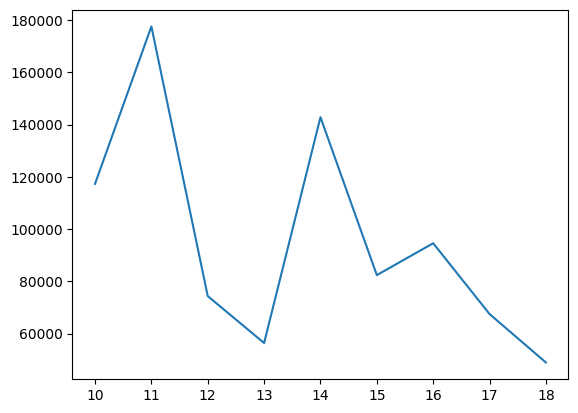

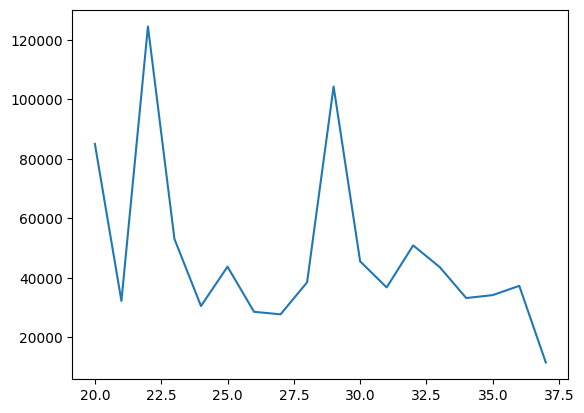

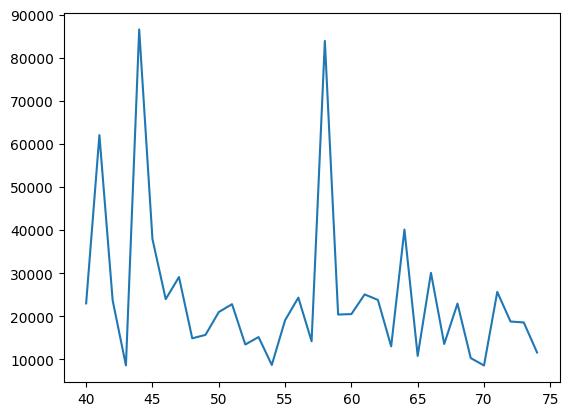

In [66]:
plt.plot(mgnt.groupby('HOUR')['VOLUME'].sum())
plt.show()
plt.plot(mgnt.groupby('HALF_OF_HOUR')['VOLUME'].sum())
plt.show()
plt.plot(mgnt.groupby('QUARTER_OF_HOUR')['VOLUME'].sum())
plt.show()

In [33]:
# MDP
# Давайте для market-making'а посмотрим задачу
# 3 функции, нужно написать каждую из них.
# Предлагаю начать с action

In [2]:
df = pd.read_csv("data/csv/stock_20210303.csv")
df['TRADENO'] = df['TRADENO'].astype('str')

In [3]:
tmp = df.TIME.astype(str).apply(lambda x: (int(x[0:2]) * 3600 + int(x[2:4]) * 60 + int(x[4:6])) * pow(10, len(x[6:])) + int(x[6:]))

In [4]:
df.TIME[8234569]

123824082646

In [5]:
action_two = df[df.ACTION == 2]
action_one = df[df.ACTION == 1]
jn = action_two.join(action_one, how='left', on='ORDERNO', rsuffix='_')

0.08050083845177562


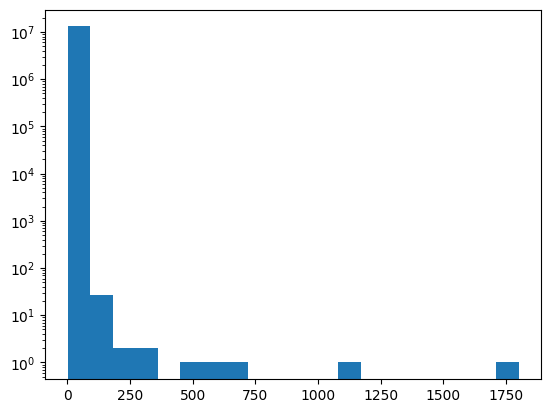

In [7]:
result = df.groupby('ORDERNO').agg({'VOLUME': ['first', 'sum']})
result.columns = [f'{col[1]}' for col in result.columns]
print(np.mean(result['sum'] / result['first'] != 2) * 100)
plt.hist(result['sum'] / result['first'], bins=20)
plt.yscale('log')
plt.show()

In [8]:
from src.exchange_env.exchange_simulator import ExchangeDataset
from src.exchange_env.exchange_simulator import Exchange

In [9]:
logs = ExchangeDataset("stock_20210303.csv", green_stocks=['GAZP'])

In [10]:
exchange = Exchange(logs.get_stocks())

In [11]:
for id, dt in enumerate(tqdm(logs.get_data(), total=len(logs))):
    time = dt['time']
    rows = dt['rows']
    exchange.execute_orders(rows)

100%|██████████| 946074/946074 [02:43<00:00, 5779.61it/s]


In [12]:
ask, bid = exchange.get_volumes()

In [13]:
min(ask[0])

(223.12, 50720)

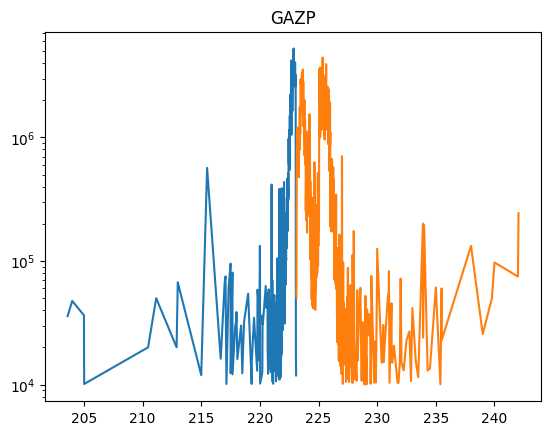

In [14]:
for i in range(len(bid)):
    plt.plot([price for price, volume in bid[i] if volume > 10000], [volume for price, volume in bid[i] if volume > 10000])
    plt.plot([price for price, volume in ask[i] if volume > 10000], [volume for price, volume in ask[i] if volume > 10000])
    plt.title(logs.get_stocks()[i])
    plt.yscale('log')
    plt.show()

In [15]:
res = exchange.get_logs()

In [16]:
len(res[0]['GAZP'])

44513934

In [17]:
exchange.stocks['GAZP'].bid_side.prices

SortedSet([203.61, 203.63, 203.7, 203.81, 204.0, 204.01, 204.1, 204.11, 204.3, 204.4, 204.42, 204.5, 204.51, 204.55, 204.63, 204.8, 204.85, 204.91, 205.0, 205.01, 205.02, 205.1, 205.12, 205.13, 205.2, 205.28, 205.4, 205.45, 205.48, 205.5, 205.55, 205.58, 205.6, 205.7, 205.76, 205.97, 205.99, 206.0, 206.01, 206.02, 206.03, 206.05, 206.11, 206.12, 206.16, 206.2, 206.24, 206.25, 206.5, 207.0, 207.01, 207.05, 207.06, 207.12, 207.13, 207.36, 207.59, 207.6, 207.76, 207.77, 207.9, 208.0, 208.2, 208.31, 208.32, 208.4, 208.42, 208.5, 208.63, 208.7, 208.82, 208.86, 208.96, 209.0, 209.01, 209.05, 209.12, 209.2, 209.3, 209.33, 209.45, 209.58, 209.67, 209.69, 209.73, 209.81, 209.88, 209.91, 209.95, 210.0, 210.01, 210.02, 210.04, 210.05, 210.08, 210.1, 210.12, 210.15, 210.16, 210.18, 210.2, 210.21, 210.22, 210.25, 210.4, 210.47, 210.5, 210.51, 210.53, 210.55, 210.6, 210.61, 210.63, 210.65, 210.68, 210.75, 210.8, 210.93, 210.94, 210.97, 211.0, 211.01, 211.02, 211.04, 211.07, 211.08, 211.09, 211.1, 21

In [18]:
alrs = df[df.SECCODE == 'ALRS'].reset_index().drop(columns=['index'])
vtbe = df[df.SECCODE == 'VTBE'].reset_index().drop(columns=['index'])

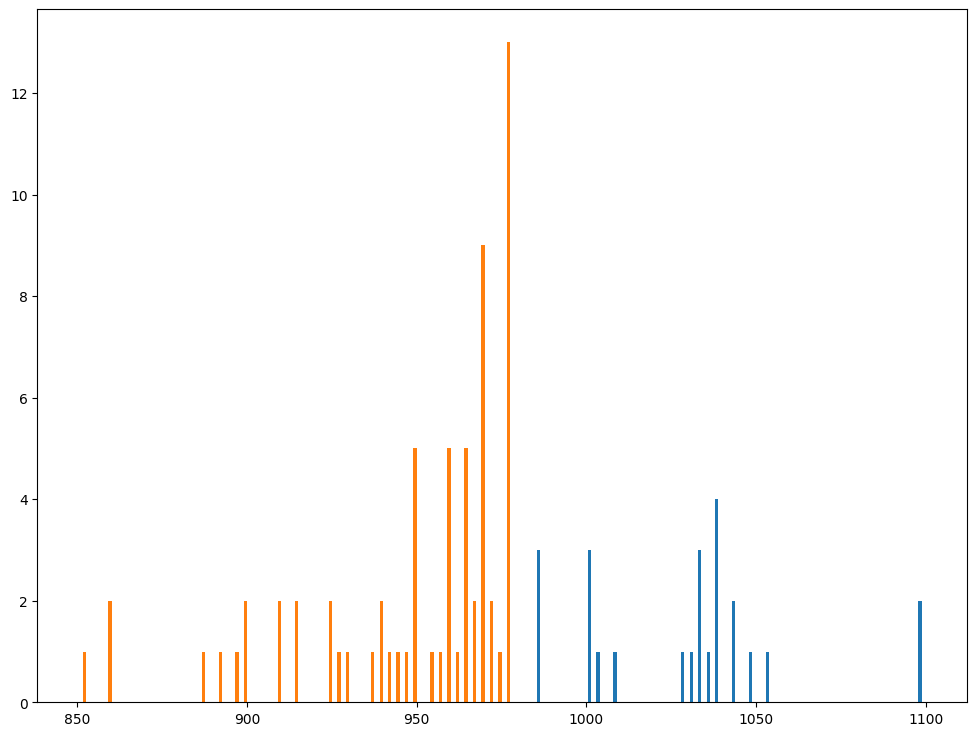

In [19]:
first = vtbe.loc[:90]
plt.figure(figsize=(12, 9))
plt.hist([first[first.BUYSELL == 'S'].PRICE, first[first.BUYSELL == 'B'].PRICE], bins=100)
plt.show()

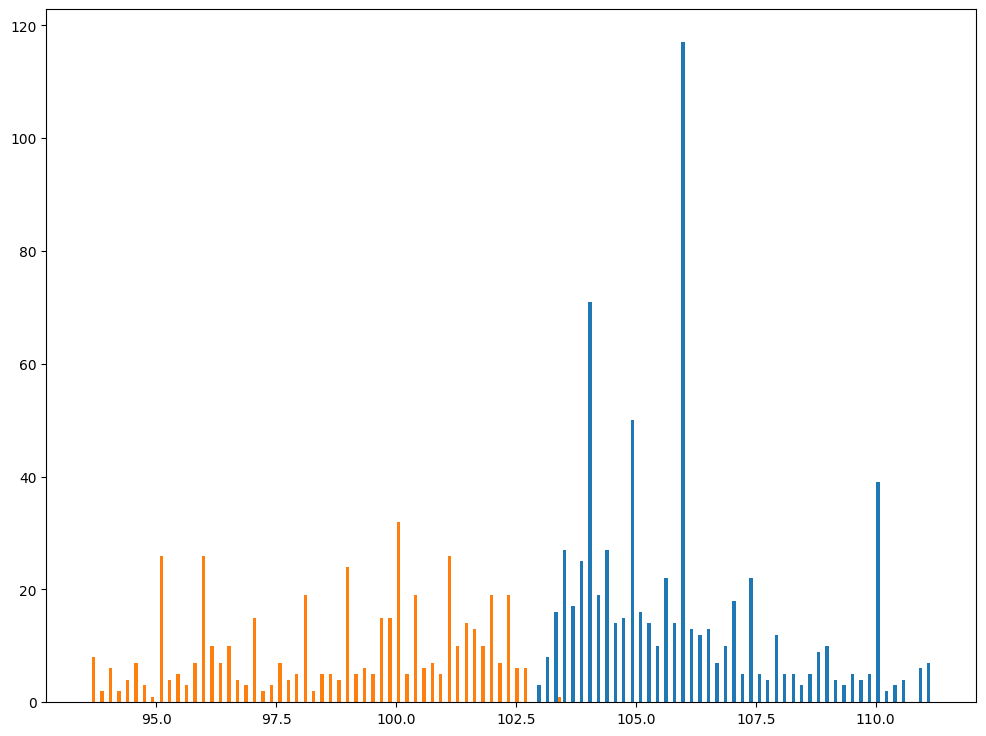

In [20]:
first = alrs.loc[:1208]
plt.figure(figsize=(12, 9))
plt.hist([first[first.BUYSELL == 'S'].PRICE, first[first.BUYSELL == 'B'].PRICE], bins=100)
plt.show()